# Subtrack and interpolate quantiles from National Blend files

In [ ]:
import sys
import time
import h5py
import pygrib
import numpy as np
from datetime import datetime, timedelta

In [2]:
import scipy.interpolate as spint
from scipy.spatial import Delaunay
import itertools

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def interp_weights(xy, uv, d=2):
    tri = Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)

In [6]:
# MRMS lat/lon
with h5py.File(save_dir+'CNN_domain.hdf', 'r') as h5io:
    lon_01 = h5io['lon_01'][...]
    lat_01 = h5io['lat_01'][...]

**National blend has irragular grids**

In [7]:
filename = '/glade/campaign/cisl/aiml/ksha/NBlend_2023/blend_20230101_t00z.qmd.f006.co.grib2'
with pygrib.open(filename) as grbio:
    lat_blend, lon_blend = apcp_temp = grbio[2].latlons()

In [8]:
# compute interpolation weights from National blend grids to 0.1 deg grids
vtx, wts = interp_weights(np.vstack([lon_blend.ravel(), lat_blend.ravel()]).T, 
                          np.vstack([lon_01.ravel(), lat_01.ravel()]).T)

In [9]:
q_bins_blend = np.arange(0.01, 1, 0.01)
grid_shape = lat_01.shape
N_bins = len(q_bins_blend)
year = 2023
N_days = 300

## Regrid and save national blend quantile values

In [10]:
base = datetime(year, 1, 1)
date_list = [base + timedelta(days=day) for day in range(N_days)]

LEADs = np.arange(6, 168+6, 6)
APCP_q = np.empty((N_days, N_bins,)+grid_shape)

In [11]:
# lead = 6

# dt = date_list[120]
# dt_str = datetime.strftime(dt, '%Y%m%d')
# name_ = '/glade/campaign/cisl/aiml/ksha/NBlend_2023/blend_{}_t00z.qmd.f{:03d}.co.grib2'.format(dt_str, lead)

In [23]:
base = datetime(year, 1, 1)
date_list = [base + timedelta(days=day) for day in range(N_days)]

#LEADs = np.arange(6, 168+6, 6)
LEADs = [6,]
APCP_q = np.empty((N_days, N_bins,)+grid_shape)

for lead in LEADs:
    APCP_q[...] = np.nan
    for t, dt in enumerate(date_list[-2:]):
        
        dt_str = datetime.strftime(dt, '%Y%m%d')
        name_ = '/glade/campaign/cisl/aiml/ksha/NBlend_2023/blend_{}_t00z.qmd.f{:03d}.co.grib2'.format(dt_str, lead)
        
        try:
            # ------- found the starting grib index for National Blend quantile values ----- # 
            i_start = 1
            with pygrib.open(name_) as grbio:
                var_list = grbio[1:]
            
            for i, var_name in enumerate(var_list):
                if 'Probability' in str(var_name):
                    continue;
                else:
                    i_start += i
                    break;
            # ------------------------------------------------------------------------------ #        
            with pygrib.open(name_) as grbio:
                for i, ind in enumerate(range(i_start, i_start+99, 1)):
                    apcp_temp = grbio[ind].values
                    apcp_interp = interpolate(apcp_temp.ravel(), vtx, wts)
                    apcp_interp[apcp_interp<0] = 0
                    APCP_q[t, i, ...] = apcp_interp.reshape(grid_shape)
        except:
            print('missing: {}'.format(name_))
                    
    # tuple_save = (APCP_q,)
    # label_save = ['APCP_q',]
    # du.save_hdf5(tuple_save, label_save, '/glade/campaign/cisl/aiml/ksha/NBlend_save/', 'NB_{}_ini00_f{:02d}.hdf'.format(year, lead))

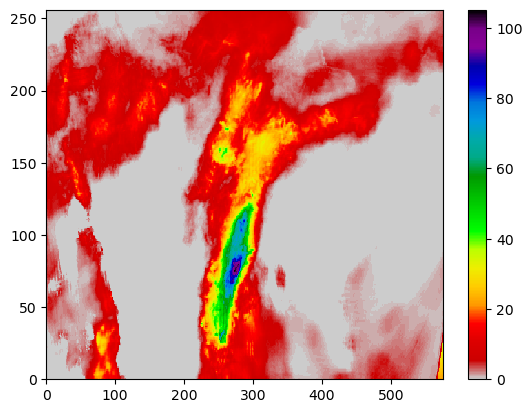

In [26]:
plt.pcolormesh(APCP_q[0, -1, ...], cmap=plt.cm.nipy_spectral_r)
plt.colorbar()

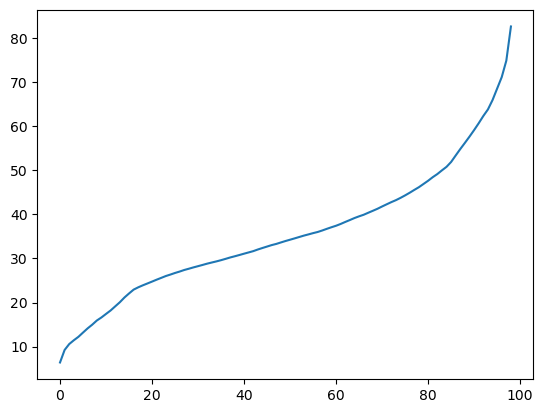

In [21]:
plt.plot(APCP_q[28, :, 200, 570]);

## Test outputs

In [ ]:
with h5py.File('/glade/campaign/cisl/aiml/ksha/NBlend_save/NB_2023_ini00_f24.hdf', 'r') as h5io:
    APCP_q = h5io['APCP_q'][...]

plt.plot(APCP_q[0, :, 150, 150])
plt.plot(APCP_q[1, :, 150, 150])
plt.plot(APCP_q[2, :, 150, 150])